<a href="https://colab.research.google.com/github/therobinkay/gender_bias_2021/blob/main/Journal_Analysis_1_(GitHub).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import all necessary packages

import io
import pandas as pd
import os
import itertools
import numpy as np
import scipy.stats
import time

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import networkx as nx
import random

import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cd "drive/My Drive"

In [ ]:
# read all necessary .csv files

data = pd.read_csv("drive/My Drive/codes/data.csv")
dp = pd.read_csv("drive/My Drive/codes/doipacs.csv")
cdata = pd.read_csv('drive/My Drive/codes/cdata.csv')
cb = pd.read_csv("drive/My Drive/codes/citationBara.csv")
cen = pd.read_csv("drive/My Drive/codes/cen.csv")

In [ ]:
prim = data[data['is_alpha'] == False]
prim = prim[prim['order'] == 1]
print(len(data))
print(len(prim))

531316
149627


# Analyses


## 0. Participation Growth

In [ ]:
data.head()

,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
0,10.1103/PhysRevSeriesI.17.267,127898,male,2,2,True,False,1903,article,PRI
1,10.1103/PhysRev.5.269,127898,male,3,3,True,False,1915,article,PR
2,10.1103/PhysRevSeriesI.16.279,127898,male,2,2,True,False,1903,article,PRI
3,10.1103/PhysRevSeriesI.16.279,59048,male,1,2,False,False,1903,article,PRI
4,10.1103/PhysRevSeriesI.5.294,9710,male,1,2,False,False,1897,article,PRI


In [ ]:
data_male = data[data['gender'] == 'male']
data_female = data[data['gender'] == 'female']

plot_m = data_male[['order', 'year']].sort_values(by=['year', 'order'])
plot_fm = data_female[['order', 'year']].sort_values(by=['year', 'order'])

In [ ]:
plt.style.use('seaborn-deep')

# bins = np.linspace(1980, 2010, 50)

plt.hist([plot_m['year'],plot_fm['year']], bins=50, label=['male', 'female'], color=('blue','orange'))
plt.yscale('log')
plt.legend(loc='upper left')
plt.title('Participation by Publication Year')
plt.xlabel('Publication Year')
# plt.ylabel('Participation Rate')
plt.ylabel('log(count)')
plt.show()

In [ ]:
plt.style.use('seaborn-deep')

plot_mp = plot_m[plot_m['order'] == 1]

plt.hist([plot_m['year'],plot_mp['year']], bins=50, label=['Total', 'Primary'], color=('blue','GREEN'))
plt.yscale('log')
plt.legend(loc='upper left')
plt.title('Male Participation by Publication Year')
plt.xlabel('Publication Year')
# plt.ylabel('Participation Rate')
plt.ylabel('log(count)')
plt.show()

In [ ]:
plt.style.use('seaborn-deep')

plot_fmp = plot_fm[plot_fm['order'] == 1]

plt.hist([plot_fm['year'],plot_fmp['year']], bins=50, label=['Total', 'Primary'], color=('orange','red'))
plt.yscale('log')
plt.legend(loc='upper left')
plt.title('Female Participation by Publication Year')
plt.xlabel('Publication Year')
# plt.ylabel('Participation Rate')
plt.ylabel('log(count)')
plt.show()

In [ ]:
plt.style.use('seaborn-deep')

plt.hist([plot_mp['year'],plot_fmp['year']], bins=50, label=['Male', 'Female'], color=('green','red'))
plt.yscale('log')
plt.legend(loc='upper left')
plt.title('Primary Participation by Publication Year')
plt.xlabel('Publication Year')
# plt.ylabel('Participation Rate')
plt.ylabel('log(count)')
plt.show()

In [ ]:
bardata = data[['order', 'year', 'gender']].sort_values(by=['year', 'order']).reset_index(drop=True)
bardata.groupby(['year', 'gender']).size().unstack().plot.bar(stacked=True, logy=True)

In [ ]:
testdata = data
print(len(testdata))

testdata.sort_values("id", inplace = True) 

testdata.drop_duplicates(subset = ["id", "year"], 
                     keep = "first", inplace = True)

print(len(testdata))
testdata.head()

318489
318489


,doi,id,gender,order,numAuthor,is_last,is_alpha,year,articleType,journal
515672,10.1103/PhysRevD.31.3183,3,male,1,2,False,False,1985,article,PRD
263539,10.1103/PhysRevB.79.184301,6,male,1,3,False,False,2009,article,PRB
348357,10.1103/PhysRevA.54.5133,7,male,1,3,False,False,1996,article,PRA
38588,10.1103/PhysRevA.60.450,7,male,1,3,False,False,1999,article,PRA
205980,10.1103/PhysRevB.44.5487,8,male,1,6,False,False,1991,article,PRB


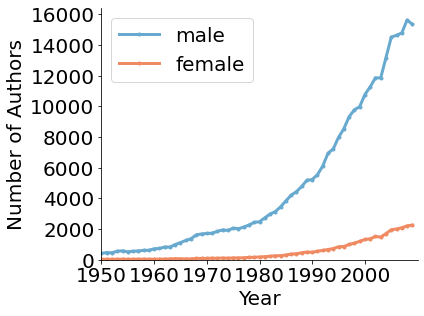

In [ ]:
tdata_m = testdata[testdata['gender'] == 'male']
tdata_fm = testdata[testdata['gender'] == 'female']

mtdata = tdata_m.groupby(['year'])['year'].count()
fmtdata = tdata_fm.groupby(['year'])['year'].count()

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

mtdata.plot(style='.-',color='#67a9cf', lw=3)
fmtdata.plot(style='.-',color='#ef8a62', lw=3)

# plt.title('Number of Authors by Year (1950-2010)')
plt.legend(('male', 'female'), loc='upper left', fontsize=20)
plt.xticks(np.arange(1950, 2010, step=10), fontsize=20)
# plt.xticks(np.arange(1960, 2010, step=10), fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950, xmax=2010)
# plt.xlim(xmin=1960, xmax=2010)
plt.ylabel('Number of Authors', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0)
# plt.figure(figsize=(10,6))

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/Figure2_1.pdf")

<Figure size 720x432 with 0 Axes>

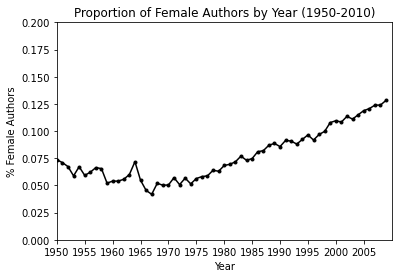

<Figure size 720x432 with 0 Axes>

In [ ]:
(fmtdata/testdata.groupby(['year'])['year'].count()).plot(style='.-', color='black')

plt.title('Proportion of Female Authors by Year (1950-2010)')
plt.xticks(np.arange(1950, 2010, step=5))
plt.xlabel('Year')
plt.xlim(xmin=1950, xmax=2010)
plt.ylabel('% Female Authors')
plt.ylim(ymin=0, ymax = 0.2)
plt.figure(figsize=(10,6))

In [ ]:
primdata = testdata[testdata['order'] == 1]

pdata_m = primdata[primdata['gender'] == 'male']
pdata_fm = primdata[primdata['gender'] == 'female']

mpdata = pdata_m.groupby(['year'])['year'].count()
fmpdata = pdata_fm.groupby(['year'])['year'].count()

# mpdata.plot(style='.-')
# fmpdata.plot(style='.-',color='orange')

# plt.title('Number of Primary Authors by Year (1950-2010)')
# plt.legend(('male', 'female'), loc='upper left')
# plt.xticks(np.arange(1950, 2010, step=5))
# plt.xlabel('Year')
# plt.xlim(xmin=1950, xmax=2010)
# plt.ylabel('Number of Primary Authors')
# plt.ylim(ymin=0)
# plt.figure(figsize=(10,6))

In [ ]:
testdata = data.copy()
# print(len(testdata))

# testdata.sort_values("id", inplace = True) 
# testdata.drop_duplicates(subset = ["id", "year"], 
#                     keep = "first", inplace = True)

# print(len(testdata))
# testdata.head()

testdata = testdata[testdata['is_alpha'] == False]
tdata_m = testdata[testdata['gender'] == 'male']
tdata_fm = testdata[testdata['gender'] == 'female']
fmtdata = tdata_fm.groupby(['year'])['year'].count()

primdata = testdata[testdata['order'] > 2]
# primdata = testdata[testdata['is_last'] == True]
primdata = primdata[primdata['is_last'] == False]
pdata_m = primdata[primdata['gender'] == 'male']
pdata_fm = primdata[primdata['gender'] == 'female']
fmpdata = pdata_fm.groupby(['year'])['year'].count()

In [ ]:
len(pdata_fm)/len(tdata_fm)

0.28697250031681665

In [ ]:
p = (len(pdata_m)+len(pdata_fm))/(len(tdata_m)+len(tdata_fm))
z = (len(pdata_m)/len(tdata_m) - len(pdata_fm)/len(tdata_fm))/math.sqrt(p*(1-p)*(1/len(tdata_m) + 1/len(tdata_fm)))

z

5.398838550109903

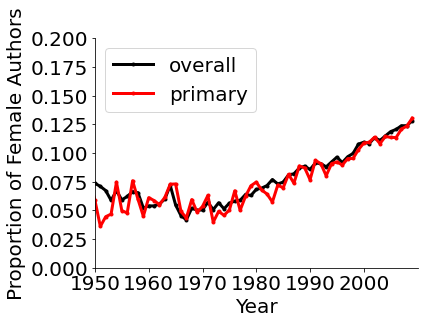

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

(fmtdata/testdata.groupby(['year'])['year'].count()).plot(style='.-', color='black', lw=3)
(fmpdata/primdata.groupby(['year'])['year'].count()).plot(style='.-', color='red', lw=3)

# plt.title('Proportion of Female Authors by Year (1950-2010)')
plt.legend(('overall', 'primary'), loc='upper left', fontsize=20)
plt.xticks(np.arange(1950, 2010, step=10), fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950, xmax=2010)
plt.ylabel('Proportion of Female Authors', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0, ymax = 0.2)

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/proportion.pdf")

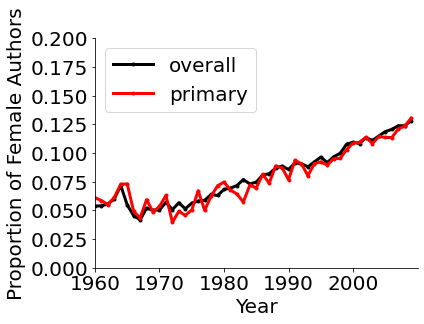

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

(fmtdata/testdata.groupby(['year'])['year'].count()).plot(style='.-', color='black', lw=3)
(fmpdata/primdata.groupby(['year'])['year'].count()).plot(style='.-', color='red', lw=3)

# plt.title('Proportion of Female Authors by Year (1950-2010)')
plt.legend(('overall', 'primary'), loc='upper left', fontsize=20)
plt.xticks(np.arange(1950, 2010, step=10), fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950, xmax=2010)
# plt.xlim(xmin=1960, xmax=2010)
plt.ylabel('Proportion of Female Authors', fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(ymin=0, ymax = 0.2)

plt.tight_layout()
# fig.savefig(f"drive/My Drive/codes/Figure2_2.pdf")
# fig.savefig(f"drive/My Drive/codes/4B_altered.pdf")

## 1. Order of Author Analysis

In [ ]:
# excluding alphabetically sorted papers

# splitting the authors by first, second, middle, last positions

first = data.query('is_alpha == False & order == 1')
second = data.query('is_alpha == False & order == 2 & is_last == False')
middle = data.query('is_alpha == False & order > 2 & is_last == False')
last = data.query('is_alpha == False & order != 1 & is_last == True')

In [ ]:
# calculating gender ratio of each position

print(first['gender'].value_counts(normalize=True))
print(second['gender'].value_counts(normalize=True))
print(middle['gender'].value_counts(normalize=True))
print(last['gender'].value_counts(normalize=True))

male      0.917101
female    0.082899
Name: gender, dtype: float64
male      0.911277
female    0.088723
Name: gender, dtype: float64
male      0.906659
female    0.093341
Name: gender, dtype: float64
male      0.91497
female    0.08503
Name: gender, dtype: float64


## 2. Productivity by Gender


In [ ]:
# Creating a DataFrame with productivity calculated
prod = data.groupby(['id', 'gender']).agg({'year': [min, max, 'count']})

prod['career_age'] = prod['year']['max'] - prod['year']['min']
prod['prod'] = prod['year']['count'] / (prod['career_age'])
prod = prod[prod['career_age'] != 0]

prod.sort_values([('year','count')], ascending=False).head()

# Dividing the DataFrame by gender
prod_m = prod.xs('male', level='gender').sort_values(
    by=['prod'],ascending=False, ignore_index=True)
prod_fm = prod.xs('female', level='gender').sort_values(
    by=['prod'],ascending=False)

In [ ]:
camale = prod_m.groupby(['career_age'])['career_age'].count()
cafemale = prod_fm.groupby(['career_age'])['career_age'].count()

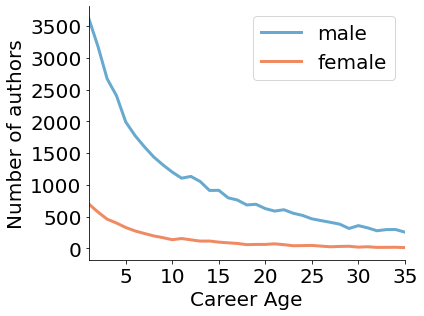

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

camale.plot(color='#67a9cf', lw=3)
cafemale.plot(color='#ef8a62', lw=3)
plt.xticks(fontsize=20)
plt.xlim(1,35)
plt.yticks(fontsize=20)
plt.legend(['male', 'female'], loc='upper right', fontsize=20)
plt.xlabel('Career Age', fontsize=20)
plt.ylabel('Number of authors', fontsize=20)
plt.tight_layout()
fig.savefig("drive/My Drive/codes/ca_count.pdf")

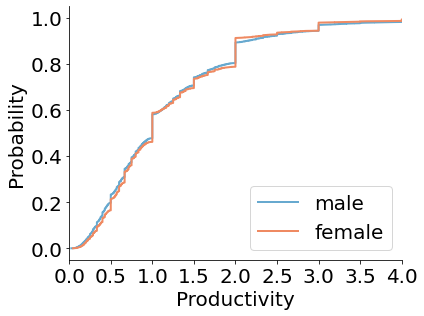

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
from scipy.interpolate import interp1d

cdf1=np.arange(len(prod_m))/float(len(prod_m)-1)
cdf2=np.arange(len(prod_fm))/float(len(prod_fm)-1)

# plt.figure(figsize=(8,6))

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot(prod_m['prod'],1-cdf1, color='#67a9cf', lw=2)
plt.plot(prod_fm['prod'],1-cdf2, color='#ef8a62', lw=2)

# plt.title('Productivity of APS authors (CDF)')
plt.xlabel('Productivity', fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(xmin=0, xmax=4)
plt.ylabel('Probability', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['male', 'female'], loc='lower right', fontsize=20)
# plt.ylim(ymin=0, ymax=0.5)
plt.tight_layout()
fig.savefig(f"drive/My Drive/codes/Figure3_1.pdf")

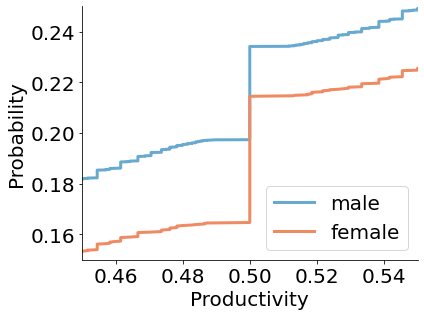

In [ ]:
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot(prod_m['prod'],1-cdf1, color='#67a9cf', lw=3)
plt.plot(prod_fm['prod'],1-cdf2, color='#ef8a62', lw=3)

# plt.title('Productivity of APS authors (CDF)')
plt.xlabel('Productivity', fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(xmin=0.45, xmax=0.55)
plt.ylabel('Probability', fontsize=20)
plt.yticks(fontsize=20)
plt.legend(['male', 'female'], loc='lower right', fontsize=20)
plt.ylim(ymin=0.15, ymax=0.25)
plt.tight_layout()
fig.savefig("drive/My Drive/codes/Figure3_2.pdf")

In [ ]:
#ks test (two-tailed)
from scipy.stats import ks_2samp
print(ks_2samp(prod_m['prod'], prod_fm['prod']))

#ks test: male > female
print(ks_2samp(prod_m['prod'], prod_fm['prod'], alternative='greater'))

#ks test: male < female
print(ks_2samp(prod_m['prod'], prod_fm['prod'], alternative='less'))

Ks_2sampResult(statistic=0.06591095931643487, pvalue=3.2496236758858577e-17)
Ks_2sampResult(statistic=0.06591095931643487, pvalue=1.546976225788144e-17)
Ks_2sampResult(statistic=-0.0, pvalue=1.0)


In [ ]:
# finding where the biggest difference occurs

def ks_2samp_x(data1, data2, alternative="two-sided"):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]

    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    cddiffs = cdf1 - cdf2
    minS = np.argmin(cddiffs)   # ks_2samp uses np.min or np.max respectively 
    maxS = np.argmax(cddiffs)   # now we get instead the index in data_all
    alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
    d_arg = alt2Dvalue[alternative]
    return data_all[d_arg]

print(ks_2samp_x(prod_m['prod'], prod_fm['prod']))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="greater"))
print(ks_2samp_x(prod_m['prod'], prod_fm['prod'], alternative="less"))

2.0
0.975609756097561
2.0


## 3. Dropout Authors by Career Age
Don't include the authors who have not written anything before 1999.

(annual year is only showing less accurate dropout)

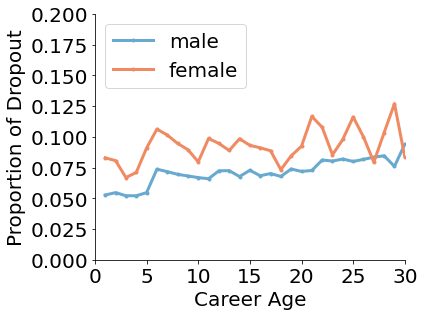

In [ ]:
# exclude authors who enter APS publication after 2004
# create (JADIDI) scatterplot of dropout authors by career age

gb = prod[prod['year']['min'] < 2004].groupby(['gender', 'career_age'])['career_age'].count()

gb_m = gb['male'].sort_index(ascending=False)
gb_fm = gb['female'].sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

(gb_m/gb_m.cumsum()).iloc[::-1].plot(style='.-', color='#67a9cf', lw=3)
(gb_fm/gb_fm.cumsum()).iloc[::-1].plot(style='.-',color='#ef8a62', lw=3)

# plt.title('Dropout Author Ratio by Career Age')
plt.legend(('male', 'female'), loc='upper left', fontsize=20)
plt.xlabel('Career Age', fontsize=20)
plt.xlim(0,30)
plt.ylabel('Proportion of Dropout', fontsize=20)
plt.ylim(0, 0.2)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
# fig.savefig("drive/My Drive/codes/Figure5.pdf")

In [ ]:
mser = (gb_m/gb_m.cumsum()).iloc[::-1]
fser = (gb_fm/gb_fm.cumsum()).iloc[::-1]

In [ ]:
mser.subtract(fser)[:30]

career_age
1    -0.030242
2    -0.025981
3    -0.014794
4    -0.018973
5    -0.036312
6    -0.032558
7    -0.029815
8    -0.025122
9    -0.021425
10   -0.012801
11   -0.032729
12   -0.022255
13   -0.016408
14   -0.030743
15   -0.020274
16   -0.022726
17   -0.018546
18   -0.005501
19   -0.010762
20   -0.020503
21   -0.043945
22   -0.026675
23   -0.005109
24   -0.015998
25   -0.036182
26   -0.018302
27    0.004104
28   -0.018819
29   -0.050971
30    0.010312
Name: career_age, dtype: float64

## 4. Citation Analysis

### 4.1 Degree Centrality Analysis

In [ ]:
# exclude alphabetically ordered papers
# only consider primary authors
degcen = data.query('is_alpha == False & order == 1')

# calculate degree centrality per paper
vc = cb['cited_doi'].value_counts()
cb_sub = vc[vc.to_numpy() > 0].to_frame()

# create a DataFrame with degree centrality
cited = pd.merge(cb_sub, degcen, left_index = True, right_on = 'doi')

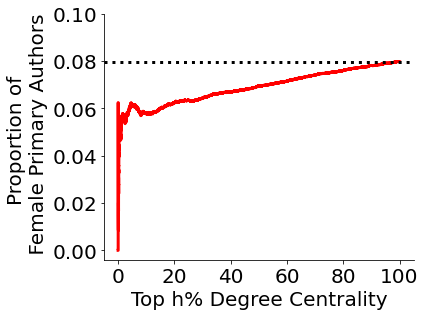

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion
cited_gender = cited['gender'].to_numpy()
cumulate_cited_gender = np.cumsum(cited_gender == "female")

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot((np.arange(len(cited))*100)/len(cited), cumulate_cited_gender/np.arange(1, len(cited)+1), color='red', lw=3)
plt.axhline(y=len(cited[cited['gender'] == 'female'])/len(cited), color='black', linestyle='dotted', lw=3)

# plt.title("Proportion of Female Primary Authors per Degree Centrality %")
plt.xlabel("Top h% Degree Centrality", fontsize=20)
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of \n Female Primary Authors", fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
fig.savefig("drive/My Drive/codes/Figure6_1.pdf")

### 4.2 Self-citation Analysis (general)


In [ ]:
# create a DataFrame with self-citing authors by gender
pop = cdata.groupby(['citing_year'])['citing_year'].count()

male = cdata.loc[cdata['citing_gender'] == 'male'].groupby(['citing_year'])['citing_year'].count()
female = cdata.loc[cdata['citing_gender'] == 'female'].groupby(['citing_year'])['citing_year'].count()

sccit = cdata.loc[cdata['citing_id'] == cdata['cited_id']].groupby(['citing_year'])['citing_year'].count()

malesc = cdata.loc[(cdata['citing_id'] == cdata['cited_id']) & (cdata['citing_gender'] == 'male')].groupby(['citing_year'])['citing_year'].count()
femalesc = cdata.loc[(cdata['citing_id'] == cdata['cited_id']) & (cdata['citing_gender'] == 'female')].groupby(['citing_year'])['citing_year'].count()

pop[np.isnan(pop)] = 0
male[np.isnan(male)] = 0
female[np.isnan(female)] = 0
sccit[np.isnan(sccit)] = 0
malesc[np.isnan(malesc)] = 0
femalesc[np.isnan(femalesc)] = 0

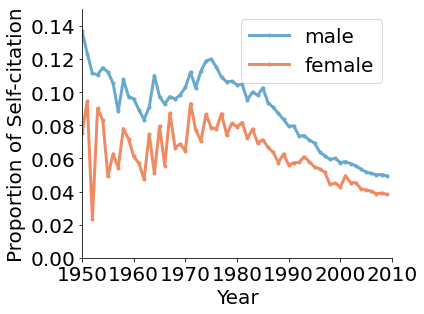

In [ ]:
# create a self-citation ratio plot by year
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

(malesc/male).plot(style='.-', color='#67a9cf', lw=3)
(femalesc/female).plot(style='.-',color='#ef8a62', lw=3)

# /plt.title('Self-citation Ratio by Year')
plt.legend(('male', 'female'), loc='upper right', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xlim(xmin=1950)
plt.xlim(xmax=2010)
plt.ylabel('Proportion of Self-citation', fontsize=20)
plt.ylim(ymin=0, ymax=0.15)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
# fig.savefig("drive/My Drive/codes/Figure7.pdf")

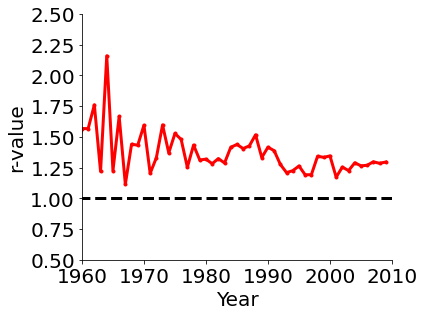

In [ ]:
# calculate k-value
k1 = ((malesc/sccit)/(femalesc/sccit))
k2 = ((female/pop)/(male/pop))
k = k1*k2

# create k-value plot
fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

k.plot(style='.-', color='red', lw=3)

# plt.title('k value by Year')
plt.xlabel('Year', fontsize=20)
# plt.xlim(xmin=1950)
plt.xlim(xmin=1960)
plt.xlim(xmax=2010)
plt.ylabel('r-value', fontsize=20)
# plt.ylim(ymin=0.5,ymax=5)
plt.ylim(ymin=0.5,ymax=2.5)
plt.hlines(1,xmin=1903,xmax=2010,linestyles='dashed', lw=3)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
# fig.savefig("drive/My Drive/codes/2C_altered.pdf")

## 5 PageRank Centrality

In [ ]:
# apply nx.graph to citation relationship network
Graphtype = nx.DiGraph()

C = nx.from_pandas_edgelist(cen, source='citing_doi',
                            target='cited_doi', create_using=Graphtype)
print(nx.info(C))

Name: 
Type: DiGraph
Number of nodes: 144813
Number of edges: 703005
Average in degree:   4.8546
Average out degree:   4.8546


In [ ]:
# observe author id & gender (primary author)
nodedata = data.query('is_alpha == False & order == 1').drop(
    ['order', 'numAuthor',	'is_last',	'is_alpha',	'year',
    'articleType',	'journal'], axis=1)
# nodedata.columns = ['id', 'Label', 'Gender']
nodedata.tail()

,doi,id,gender
531302,10.1103/PhysRevLett.98.068101,13234,male
531304,10.1103/PhysRevE.76.017301,148679,female
531305,10.1103/PhysRevSTPER.3.020101,120132,male
531310,10.1103/PhysRevSTPER.4.010102,48834,male
531311,10.1103/PhysRevSTPER.4.010108,2668,male


In [ ]:
print(len(nodedata))
nodedata.id.nunique()

149627


32827

In [ ]:
# assign PageRank centrality to each paper
pr = nx.pagerank(C)

# create a centrality dataframe
prs = pd.DataFrame()
prs['doi'] = pr.keys()
prs['PRcen'] = pr.values()

# merge and create a dataframe: id, gender, PageRank centrality
prs_new = prs.merge(nodedata, left_on='doi', right_on='doi',
                how='left')
# prs_new = prs_new[['id', 'Gender', 'centrality']].sort_values(
    # 'centrality', ascending=False)
prs_new = prs_new.sort_values('PRcen', ascending=False)
prs_new.head()

,doi,PRcen,id,gender
3189,10.1103/PhysRev.47.777,0.001368,38494,male
25816,10.1103/PhysRevLett.55.2471,0.001325,187091,male
49819,10.1103/PhysRevLett.28.240,0.001062,80536,male
54770,10.1103/PhysRev.156.583,0.000961,118337,male
20116,10.1103/PhysRev.106.364,0.000918,73416,male


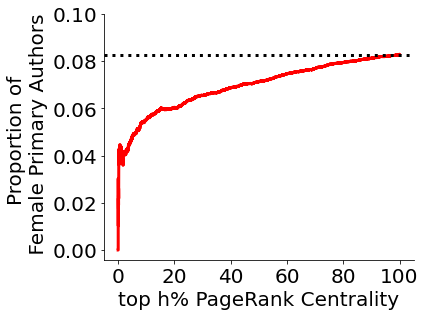

In [ ]:
# Comparative graph for actual female proportion vs. expected female proportion

prs_gender = prs_new['gender'].to_numpy()
cumulate_prs_gender = np.cumsum(prs_gender == "female")

fig, ax = plt.subplots(figsize=(6,4.5))
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)

plt.plot((np.arange(len(prs_new))*100)/len(prs_new),
         cumulate_prs_gender/np.arange(1, len(prs_new)+1), color='red', lw=3)
plt.axhline(y=0.08274119036274367, color='black', linestyle='dotted', lw=3)

# plt.title("Proportion of Female Primary Authors per PageRank Centrality")
plt.xlabel("top h% PageRank Centrality", fontsize=20)
plt.ylim(ymax=0.1)
plt.ylabel("Proportion of \n Female Primary Authors", fontsize = 20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
# fig.savefig("drive/My Drive/codes/Figure6_2.pdf")

## 5.1 PageRank Centrality among Similar Papers

In [ ]:
############## SELECT DESIRED PACS (HOMOPHILY ONLY) ###############

homn = pd.read_csv("drive/My Drive/codes/hom0.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom1.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom2.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom3.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom4.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom5.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom6.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom7.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom8.csv")
# homn = pd.read_csv("drive/My Drive/codes/hom9.csv")

print(len(homn))
homn.head()

1189255


,paper1,gender1,year1,paper2,gender2,year2,qval,k
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.1617,male,1986,0.001230,False
1,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False
2,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.41.784,male,1990,0.017857,False
3,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False
4,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False


In [ ]:
# Calculate cen_d (male centrality - female centrality)

prs_sim = prs.merge(nodedata, left_on='doi', right_on='Label',
                    how='left').drop(['Label'], axis=1)
prs_sim = prs_sim[["doi", 'id', 'Gender', 'centrality']].sort_values(
    'centrality', ascending=False)

ph = pd.merge(homn, prs_sim, left_on = "paper1", right_on = "doi", how = "left")
ph = ph.drop(["doi", "id", "Gender"], axis=1)
ph = ph.rename(columns={"centrality": "cen1"})

ph = ph.merge(prs_sim, left_on = "paper2", right_on = "doi", how = "left")
ph = ph.drop(["doi", "id", "Gender"], axis=1)
ph = ph.rename(columns={"centrality": "cen2"})
print(len(ph))

ph = ph[ph['gender1'] != ph['gender2']].reset_index(drop=True)

listd = []

for c in range(len(ph)):
  if ph['gender1'][c] == 'male':
    listd.append(ph['cen1'][c] - ph['cen2'][c])
  else:
    listd.append(ph['cen2'][c] - ph['cen1'][c])

ph['cen_d'] = listd

print(len(ph))
ph.head()

1189255
184694


,paper1,gender1,year1,paper2,gender2,year2,qval,k,cen1,cen2,cen_d
0,10.1103/PhysRevA.30.336,male,1984,10.1103/PhysRevA.34.4472,female,1986,0.017857,False,0.000018,0.000004,1.402271e-05
1,10.1103/PhysRevA.34.4472,female,1986,10.1103/PhysRevA.41.784,male,1990,0.017857,False,0.000004,0.000005,7.764608e-07
2,10.1103/PhysRevA.36.4950,female,1987,10.1103/PhysRevA.41.784,male,1990,0.006410,False,0.000002,0.000005,2.824713e-06
3,10.1103/PhysRevA.39.5466,female,1989,10.1103/PhysRevA.41.784,male,1990,0.006410,False,0.000002,0.000005,2.166712e-06
4,10.1103/PhysRevA.41.3081,female,1990,10.1103/PhysRevA.41.784,male,1990,0.000511,False,0.000002,0.000005,2.824713e-06


In [ ]:
# Extract subDataFrame with q-value less than p threshold

p = 0.002 # Select p thresholds with listed numbers in the paper

phsub = ph[ph['qval'] < p].sort_values('cen_d').reset_index(drop=True)

mlist = []
fmlist = []

for i in range(len(phsub)):
  if phsub['gender1'][i] == 'male':
    mlist.append(phsub['cen1'][i])
    fmlist.append(phsub['cen2'][i])
  else:
    mlist.append(phsub['cen2'][i])
    fmlist.append(phsub['cen1'][i])

# Find the standard deviation
sd = math.sqrt((np.std(mlist) ** 2 + np.std(fmlist) ** 2)/len(phsub))

# Find z-scores (for p-values)
print((np.mean(mlist)-np.mean(fmlist))/sd)

-0.6457704432323805
